# Imports

In [11]:
import numpy as np
import pandas as pd
import os

#from scipy.optimize import curve_fit
import scipy

import matplotlib.pyplot as plt
#%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin 

#%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [12]:
def absfluo_extractor(typ, abs_lmda, dframe):
    """This function returns a df which can be merged
    with temp df append the measurements"""
    typ = typ
    
    abs_lmda = abs_lmda
    
    tdf =  df.loc[(df['type']==typ) & (df['wavelen']==abs_lmda)][['well','measurement']].set_index(keys='well')     
    
    return tdf.rename({'measurement':typ[0]+abs_lmda[0:3]}, axis=1)


def get_row_col_values(df, plate_row_or_col='row', df_col_name='A680'):
    """This function returns the values of either a row or column of the 96 well
    as given in the dataframe. These values are later used to perform a linear 
    regression using scipy.optimize function
    Ronnie Sidney
    ROW refers to the chlamy related values, and COL to the bacteria related ones"""
    
    rows = df['row'].unique()
    cols = df['col'].unique()
    
    values_list = []
    if plate_row_or_col=='row':
        for row in rows:
            values_list.append(df.loc[df['row']==row, df_col_name].to_list())
    
    else:
        for col in cols:
            values_list.append(df.loc[df['col']==col, df_col_name].to_list())
                               
    
    return values_list


# linear curve
def linear_curve(parameters, xdata):
    """
    A680 & A750 show a linear relationship:
    y = m*x + b
    
    m = slope
    b = y-intercept
    """
    m = parameters[0]
    b = parameters[1]
    
    return m*xdata + b


def linear_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [C] || [B]  (Regresso)
    
    ydata = A680 || A750
    
    Computes the residuals of y_pred -y_obs, where:
        y_pred = line(parameters, xdata)
    """
    
    return linear_curve(parameters,xdata) - ydata


def root_curve(parameters, xdata):
    """
    F680 shows an obvious root-function relationship:
    
    y = a√(b*x)
    
    'a' and 'b' control area under the curve with
    'b' doing so much more slowly
    
    NOTE: 
        
        the following permutations of this model were
        also made :
            y = √(b*x)
            y = a√(x)
        
        however these mono-parameter models produce large
        coefficients thus the best model to use is below:
            y = a√(b*x)
    
    """
    
    a = parameters[0]
    b = parameters[1]
    
    return a*np.sqrt(b*xdata)


def root_curve_residuals(parameters, xdata, ydata, function):
    """
    xdata = [chlamy] or [bacter]
    
    ydata = observed F680
    
    Computes the residuals of y_pred - y_obs, where
    y_pred = root_curve(parameters, xdata)
    
    """
    
    return root_curve(parameters, xdata) - ydata


def scipy_optfit_caller(regressor, regressand, x0=[0,0], abfl='abs'):
    """This function returns the fitted parameter for every pair of regressor
    i.e. Concentration/Labels/Absorbance @! 680||720 wavelengths using the
    scipy.optimize least squares function and regressand
    i.e. the measured signal at the A680 and A750 wavlengths
    """
    parameters = []
    if abfl=='fluo':
        funk = root_curve_residuals
        funk2= root_curve
    else:
        funk = linear_curve_residuals
        funk2= linear_curve
        
    for ys in regressand:
        optmize_result = scipy.optimize.least_squares(funk, x0,
                                                     args = (regressor, ys, funk2))
        parameters.append(optmize_result.x)
    
    return parameters

In [13]:
def plot_fitted_k_curves(df, wav='A680', abfl='abs'):
    """This function plots the fitted paramters as curves, this is done to
    abstract away the noise from the regression on each of the rows and 
    columns. Through this we can observe the 'True' behavior of the signal
    as they change with their respective gradients """
    
    

    plt.figure(figsize=(8,10))
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(plt.subplot(gs[r,c]))

    chlamy_cnt = df['C_lbl'].unique()
    bacter_cnt = df['B_lbl'].unique()
    
    if abfl=='fluo':
        funk=root_curve
        x0=[1,1]
    else:
        x0=[0,0]
        funk=linear_curve
    
    kB = scipy_optfit_caller(bacter_cnt, get_row_col_values(df, 'col', wav), x0, abfl=abfl)
    kC = scipy_optfit_caller(chlamy_cnt, get_row_col_values(df, 'row', wav), x0, abfl=abfl)
    
    # set the ylim
    ymx=df[wav].max()
    
    xmock = np.linspace(0, .26, 25)       
    for kc in kC:
        
        axes[0].plot(xmock, funk(kc, xmock))
        axes[0].set_xlabel('[chlamy]')
        axes[0].set_ylabel(abfl)
        axes[0].set_title(wav+' @ k=[bacter] | Fitted Curves')
        axes[0].set_ylim(-0.1, ymx)

    axes[0].legend(bacter_cnt, title='[bacter]')
    
   
    xmock = np.linspace(0, .26, 25)
    for kb in kB:

        axes[1].plot(xmock, funk(kb, xmock))
        axes[1].set_xlabel('[bacter]')
        axes[1].set_ylabel(abfl)
        axes[1].set_title(wav+' @ k=[chlamy] | Fitted_Curves')
        axes[1].set_ylim(-0.1, ymx)

    axes[1].legend(chlamy_cnt, title='[chlamy]', ncol=2, prop={'size':10})


    return plt.tight_layout()
    

In [14]:
def plot_col_rows_values(df, wav='A680'):
    """This function plots the extracted values from the rows
    and columns of the 96well plate data as given by the
    get_row_col_values() function. Choose the row col values for the
    same wavelength"""
    
    
    col_vals = get_row_col_values(df, 'col', wav)
    bacter_cnt = df['B_lbl'].unique()
    
    row_vals = get_row_col_values(df, 'row', wav)
    chlamy_cnt = df['C_lbl'].unique()
    
    
    fig=plt.figure(figsize=(8,10))

    #subplots
    gs = gridspec.GridSpec(2, 1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(plt.subplot(gs[r,c]))

    ymax=df[wav].max()+0.05
    axes[0].set_ylim(-0.1, ymax)
    axes[0].set_title(wav+" @ Constant [bacter]")
    for l in row_vals:
        axes[0].plot(chlamy_cnt, l, marker='*')
        axes[0].set_ylabel('Abs | Fluo')
        axes[0].set_xlabel('[chlamy]')
        axes[0].legend(bacter_cnt, title='[bacter]')


    axes[1].set_ylim(-0.1, ymax)
    axes[1].set_title(wav+" @ Constant [chlamy]")
    for l in col_vals:
        axes[1].plot(bacter_cnt, l, marker='*')
        axes[1].set_ylabel('Abs | Fluo')
        axes[1].set_xlabel('[bacter]')
        axes[1].legend(chlamy_cnt, title='[chlamy]',
                       ncol=2, prop={'size':8})

    return plt.tight_layout()


# Data

In [15]:


dirname='../data_o/calibration/single_species_calibration/raw_data'
fname = 'abs-fluo_exp1_main.csv'

df_main = pd.read_csv(pjoin(dirname,fname), index_col=0)
df_main.head()

,row,col,B_lbl,C_lbl,F680,A680,A750
well,,,,,,,
A1,A,1,0.200,0.25,4669.0,0.8037,0.5047
B1,B,1,0.175,0.25,4835.0,0.8649,0.5056
C1,C,1,0.150,0.25,4641.0,0.7752,0.4730
D1,D,1,0.125,0.25,4778.0,0.7808,0.4494
E1,E,1,0.100,0.25,4939.0,0.7615,0.4315


In [16]:
########################
# use corrected values #
########################
for col in df_main.columns[4:].values:
    #subtract 'blank' well values
    df_main.loc[:,col] = df_main.loc[:,col] - df_main.loc['H12',col]

# Data Viz | Alternative
    
    create list of absorbance and fluorescence values and then visualize them under one figure
    

    #1 plot absorbace data on one figure

        # Alternative plots as substiutes for broad overview:
        # ----- Rows -------
        # - A680 v. [chlamy]
        # - A750 v. [chlamy] 

        #--- Cols ---------
        # - A750 v. [bacter] 

    #2 plot fluorescence data on one figure

        # --- Rows ---------
        # - F680 v. [chlamy]


        #--- Cols --------- <<<<----doubtful that this is very informative
        # - F680 v. [bacter] 

### A680

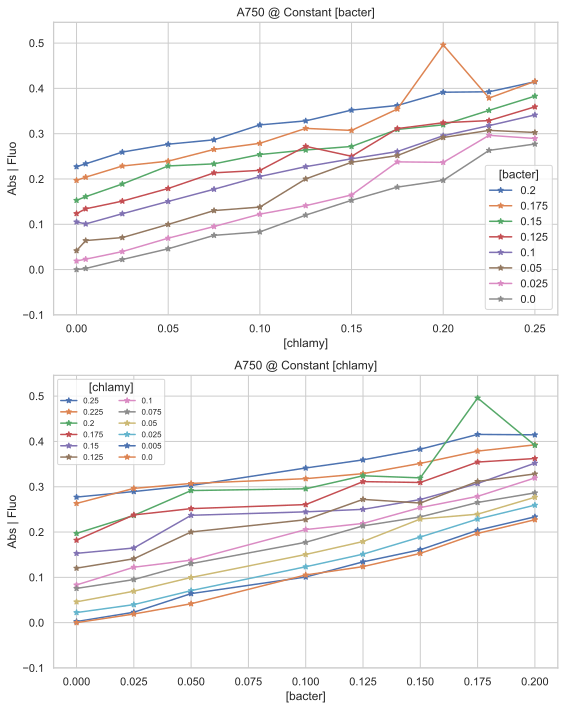

In [17]:
plot_col_rows_values(df_main, wav='A750')

### A750

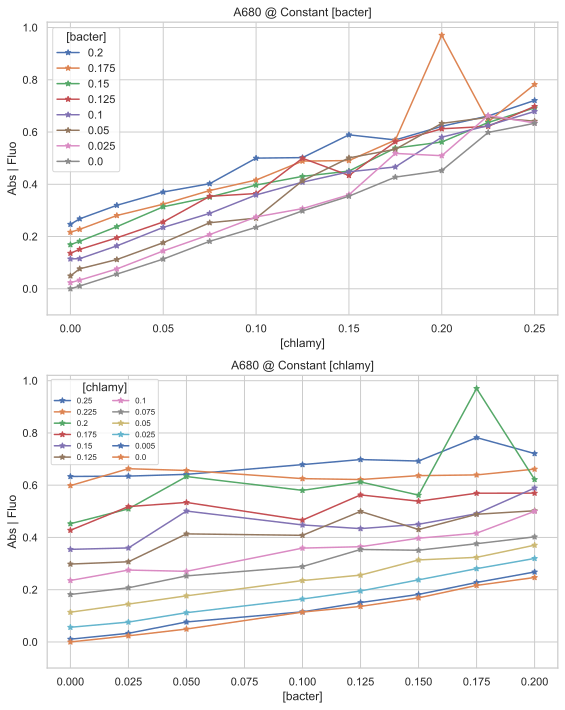

In [18]:
plot_col_rows_values(df_main, wav='A680')

### F680

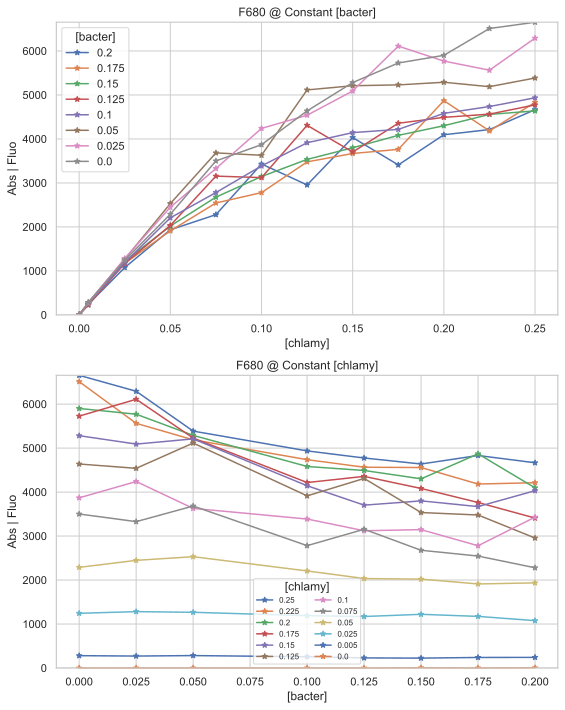

In [19]:
plot_col_rows_values(df_main, wav='F680')

# Curve Fitting



### Parameter Fitting

In [20]:
# Note: For a given row (e.g. 'A'), the constant is a [bacter] 
#       For a given col (e.g. '1'), the constant is a [chlamy]

# store absorbance values that will be plotted on one figure  [chlamy]
A680_C = get_row_col_values(df_main, 'row', df_col_name='A680')
A750_C = get_row_col_values(df_main, 'row', df_col_name='A750')
F680_C = get_row_col_values(df_main, 'row', df_col_name='F680')
# store absorbance values that will be plotted on one figure  [bacteria]
A680_B = get_row_col_values(df_main, 'col', df_col_name='A680')
A750_B = get_row_col_values(df_main, 'col', df_col_name='A750')
F680_B = get_row_col_values(df_main, 'col', df_col_name='F680')


chlamy_cnt = df_main['C_lbl'].unique()
bacter_cnt = df_main['B_lbl'].unique()

# double equivalance in order to avoid debugging previous work that uses
# the second (params...) variable namaes
kB_A680 = params_A680_C  = scipy_optfit_caller(bacter_cnt, A680_B)
kC_A680 = params_A680_B  = scipy_optfit_caller(chlamy_cnt, A680_C)
kB_A750 = params_A750_C  = scipy_optfit_caller(bacter_cnt, A750_B)
kC_A750 = params_A750_B  = scipy_optfit_caller(chlamy_cnt, A750_C)

kB_F680 = scipy_optfit_caller(bacter_cnt, F680_B, x0=[0,0], abfl='abs')
kC_F680 = scipy_optfit_caller(chlamy_cnt, F680_C, x0=[1,1], abfl='fluo')

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


# Fitted Curves Viz
### A680

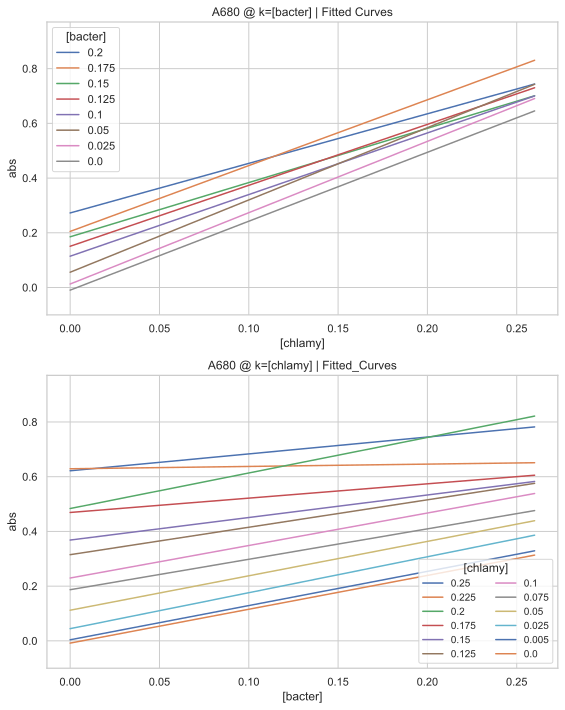

In [21]:
plot_fitted_k_curves(df_main, wav='A680')

### A750 

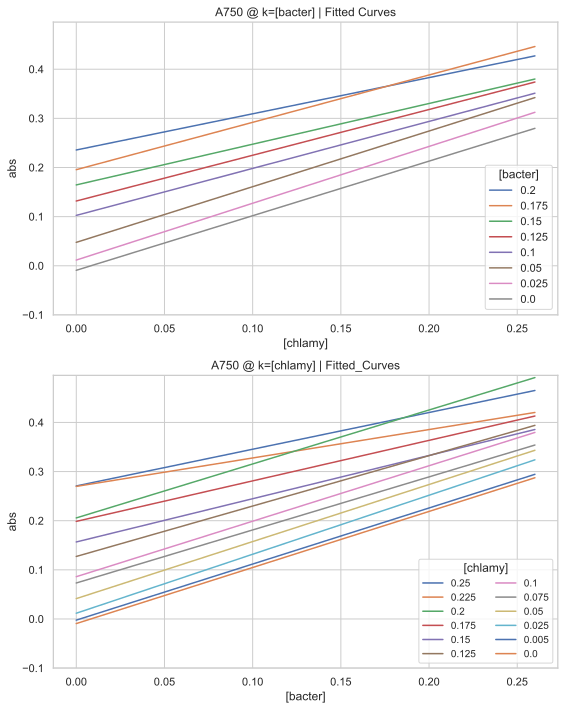

In [22]:
plot_fitted_k_curves(df_main, wav='A750')

### F680 | 2-Parameters

    # The F680 curves were fit using 1-3 konstants, but
    # the best fit came with 2 konstant

/home/rdmtinez/program_files/anaconda3/envs/fluxy/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in sqrt


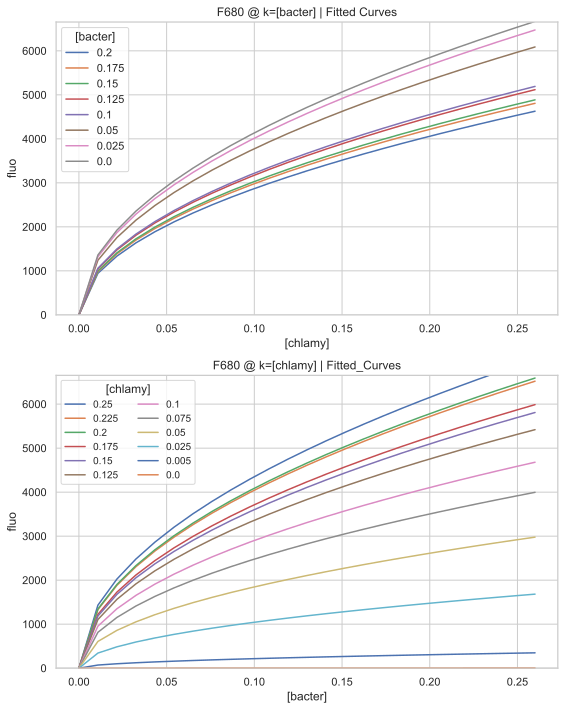

In [23]:
plot_fitted_k_curves(df_main, wav='F680', abfl='fluo')


# Ignore the second plot in this series, it is an artifact and does not represent an 
# actual coherent regression of the values 

# Extended Graphs
### A680e

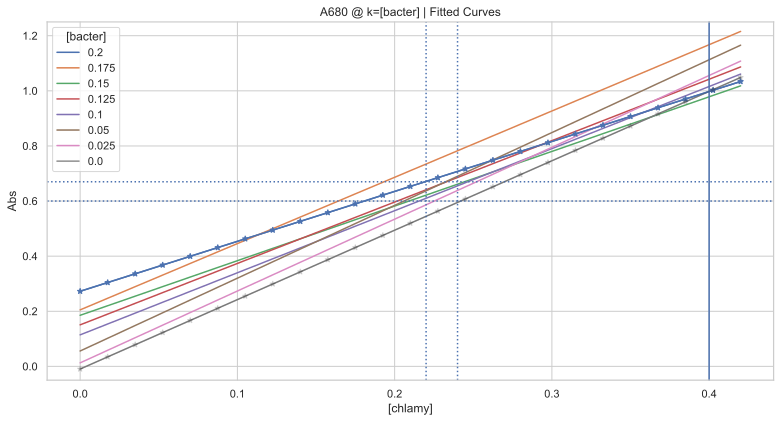

In [24]:

plt.figure(figsize=(11,6))
xmock = np.linspace(0, .42, 25)
for mb in params_A680_B:
    
    plt.plot(xmock, linear_curve(mb, xmock))
    plt.xlabel('[chlamy]')
    plt.ylabel('Abs')
    plt.title('A680 @ k=[bacter] | Fitted Curves')
    plt.ylim(-0.05, 1.25)


plt.axvline(x=.40, linestyle='-')
plt.axhline(y=.67, linestyle=':')
plt.axhline(y=.60, linestyle=':')
plt.axvline(x=.22, linestyle=':')
plt.axvline(x=.24, linestyle=':')    
plt.plot(xmock, linear_curve(params_A680_B[0], xmock), 'b-*')
plt.plot(xmock, linear_curve(params_A680_B[7], xmock), 'k-*', alpha=.15)

plt.legend(bacter_cnt, title='[bacter]')
plt.tight_layout()
plt.savefig('Fitted A680 BACTER_extended.pdf')

### A750e
    
    # Note: The following graphs below show how bacterial concentration measurements
    @ A750 are affected only in the singal amplitude between the 0 < [bacter] < 3. 
    This tells me its a good proxy for qualitatively determining the amount of bacteria
    in the system

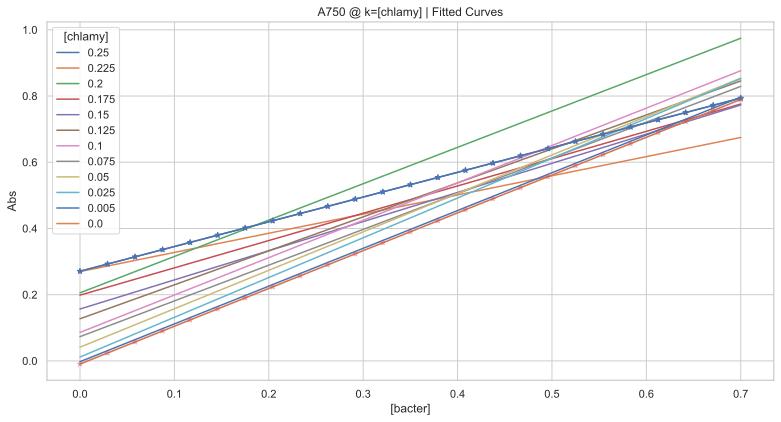

In [25]:
xmock = np.linspace(0, .7, 25)
plt.figure(figsize=(11,6))
for mb in params_A750_C:
    
    plt.plot(xmock, linear_curve(mb, xmock))
    plt.title('A750 @ k=[chlamy] | Fitted Curves')
    plt.xlabel('[bacter]')
    plt.ylabel('Abs')

plt.legend(chlamy_cnt, title='[chlamy]')
plt.plot(xmock, linear_curve(params_A750_C[0], xmock), 'b-*')
plt.plot(xmock, linear_curve(params_A750_C[11], xmock), 'r-*', alpha=.3)

plt.tight_layout()
plt.savefig('Fitted A750 CHLAMY_extended.pdf')

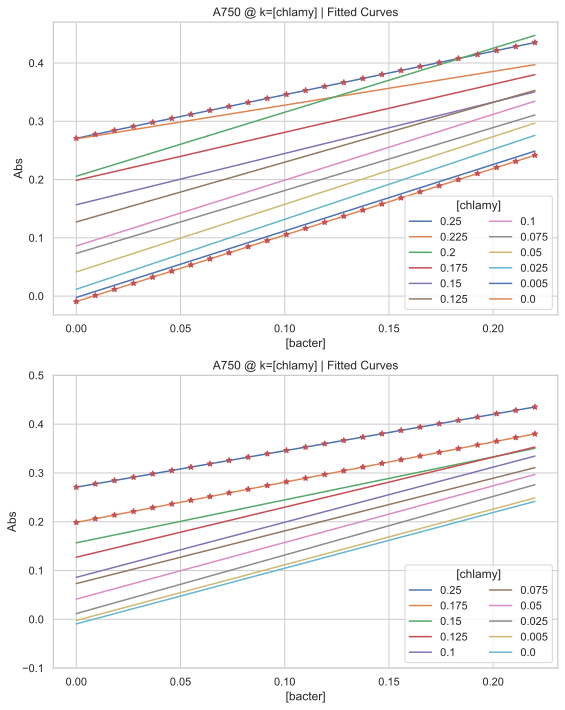

In [26]:
plt.figure(figsize=(8,10))

gs = gridspec.GridSpec(2,1)
axes = []
for r in [0,1]:
    for c in [0]:
        axes.append(plt.subplot(gs[r,c]))
        
        
xmock = np.linspace(0, .22, 25)
for mb in params_A750_C:
    
    axes[0].plot(xmock, linear_curve(mb, xmock))
    axes[0].set_title('A750 @ k=[chlamy] | Fitted Curves')
    axes[0].set_xlabel('[bacter]')
    axes[0].set_ylabel('Abs')
    
axes[0].plot(xmock, linear_curve(params_A750_C[0], xmock), 'r*')
axes[0].plot(xmock, linear_curve(params_A750_C[11], xmock), 'r*')
axes[0].legend(chlamy_cnt, title='[chlamy]', ncol=2)




idx = [0,3,4,5,6,7,8,9,10,11]
params = [params_A750_C[i] for i in idx]
legend = [chlamy_cnt[i] for i in idx]

for par in params:
    axes[1].plot(xmock, linear_curve(par,xmock))
    axes[1].set_title('A750 @ k=[chlamy] | Fitted Curves')
    axes[1].set_xlabel('[bacter]')
    axes[1].set_ylabel('Abs')
    axes[1].set_ylim(-0.1, .5)

axes[1].legend(legend, title='[chlamy]', ncol=2)
axes[1].plot(xmock, linear_curve(params_A750_C[0], xmock), 'r*')
axes[1].plot(xmock, linear_curve(params_A750_C[3], xmock), 'r*')

plt.tight_layout()
plt.savefig('Fitted A750 CHLAMY.pdf')

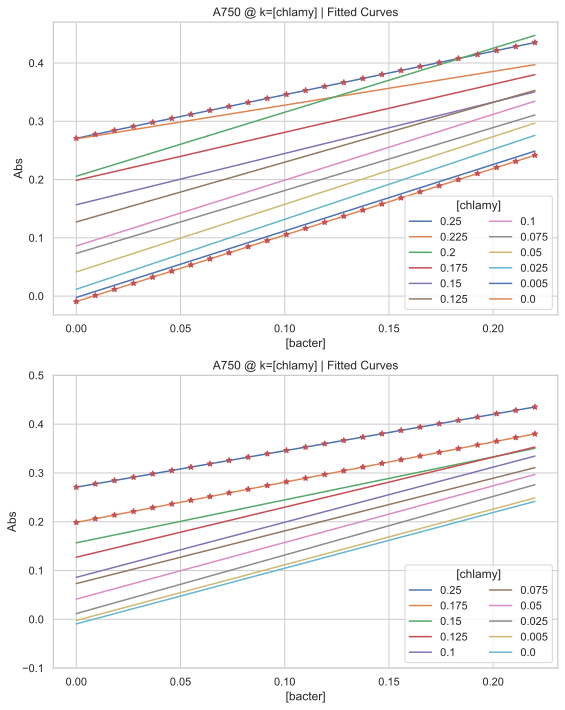

In [27]:
plt.figure(figsize=(8,10))

gs = gridspec.GridSpec(2,1)
axes = []
for r in [0,1]:
    for c in [0]:
        axes.append(plt.subplot(gs[r,c]))
        
        
xmock = np.linspace(0, .22, 25)
for mb in params_A750_C:
    
    axes[0].plot(xmock, linear_curve(mb, xmock))
    axes[0].set_title('A750 @ k=[chlamy] | Fitted Curves')
    axes[0].set_xlabel('[bacter]')
    axes[0].set_ylabel('Abs')
    
axes[0].plot(xmock, linear_curve(params_A750_C[0], xmock), 'r*')
axes[0].plot(xmock, linear_curve(params_A750_C[11], xmock), 'r*')
axes[0].legend(chlamy_cnt, title='[chlamy]', ncol=2)




idx = [0,3,4,5,6,7,8,9,10,11]
params = [params_A750_C[i] for i in idx]
legend = [chlamy_cnt[i] for i in idx]

for par in params:
    axes[1].plot(xmock, linear_curve(par,xmock))
    axes[1].set_title('A750 @ k=[chlamy] | Fitted Curves')
    axes[1].set_xlabel('[bacter]')
    axes[1].set_ylabel('Abs')
    axes[1].set_ylim(-0.1, .5)

axes[1].legend(legend, title='[chlamy]', ncol=2)
axes[1].plot(xmock, linear_curve(params_A750_C[0], xmock), 'r*')
axes[1].plot(xmock, linear_curve(params_A750_C[3], xmock), 'r*')

plt.tight_layout()

In [19]:
# 4 create the following

# ---------------------------M = slope of curve---------------------------
#
# plot: A750_Mi v. [bacter] ---- i.e. best fit curve
    #################ANALYSIS##########################
    # the slopes are quite parallel unlike 

# plot: 680_Mi v. [bacter] ---- i.e. best fit curve
#
# - I expect that the each plot's slope for a given wavelen
# - is equivalent to all others M1=M2=...=Mn


# ---------------------------A = area between curves----------------------
# plot: Ai v. [bacter]  | Ai = A_680 - A_750
#
# - I expect that the areas are also all equivalent A1=A2=...=Mn
# ------------------------------------------------------------------------

In [20]:
# ---------------------------M = slope of curve---------------------------
# plot: 750_Mi v. [chlamy]
#
# - I expect that the each plot's slope is
# - equivalent to all others M1=M2=...=Mn = M_ave
#
# plot: d[Mi] vs [chlamy] & d|y-int| vs [chlamy]
# - I expected that amplitude of the A750 curve
# - is linearly dependent on [chlamy], both the
# - d[Mi] & d|y-int| should equal
# -------------------------------------------------------------------------

In [21]:
# ---------------------------A = area under curves----------------------
# plot: Ai v. [bacter] 
# - I expect that the areas show this (-)linear dependency
# ------------------------------------------------------------------------